# СМО с взаимопомощью и без очереди (M/M/n/0)

СМО с взаимопомощью:
* Взаимопомощь между каналами обслуживания
* Если поступает заявка, когда каналы свободны, то она обслуживается всеми каналами
* Если поступает заявка числом меньше каналов, то она обслуживается частью каналов
* Если поступает заявка в момент, когда обслуживаются заявки числом меньше, чем (число каналов + число мест в очереди), то она встает в очередь
* В остальных случаях заявка покидает систему

СМО без очереди:
* Не учитывается очередь

Состояния системы:
* $S_0$ - состояние, когда все каналы свободны
* $S_1$ - состояние, когда одна заявка обслуживается всеми n каналами
* $S_2$ - состояние, когда две заявки обслуживаются всеми n каналами
* $S_n$ - состояние, когда n заявки обслуживаются n каналами

Параметры:
* $n$ - кол-во каналов
* $\lambda$ - интенсивность потока заявок
* $\mu_n = n\mu$ - интенсивность потока обслуживания заявки

## Дискретно-событийное моделирование

In [532]:
import numpy as np

In [924]:
channels = 2
l = 1
mu = 10
mu = channels*mu

params = {
'channels': channels,
'l': l,
'mu': mu,
'samples': 1_000,
'jobs': 5
}

In [925]:
print('Среднее время прихода заявки: ', 1/params['l'])
print('Среднее время обработки заявки: ', 1/params['mu'])

Среднее время прихода заявки:  1.0
Среднее время обработки заявки:  0.05


In [926]:
def get_process(time_between_events, **params):
    """
    Собирает события из процесса СМО
    Returns:
        tuple: пара списков (список со временем прибытий заявок и список со временем уходов заявок по завершении обслуживания)
    """
    assert np.all(time_between_events>0)
    
    l = params['l'] 
    mu = params['mu']
    n = params['channels']
    
    t = np.cumsum(time_between_events)
    c = [t[0]+ np.random.exponential(scale = 1/l)]
    while t.size>1:
        # queries_nb = np.argmin(c[-1]>t) + 1
        # event = min(queries_nb, n) - 1
        
        queries_nb = np.argmin(c[-1]>t)
        if queries_nb==0:
            queries_nb = len(t)
        
        event = min(queries_nb, n) - 1
        
        # print(queries_nb)
        # print(event)
        
        if queries_nb>n:
            # print(np.arange(n, queries_nb))
            t = np.delete(t, np.arange(n, queries_nb))
            if t.size<=1:
                continue
        
        
        # print(t.size)
        # print(c[-1])
        # print(t)
        # print(len(c))
        # print()
        assert event>=0
        handling_time = np.random.exponential(scale = 1/l)
        c_i = (t[1] + handling_time) if event == 0 else (c[-1] + handling_time)
        c.append(c_i)
        t=np.delete(t, 0)
    return np.cumsum(time_between_events), np.array(c)

In [953]:
def get_events(t,c, **params):
    """
    Выдает последовательность событий
    """
    n = params['channels']
    events = [0,]
    t, c = t.copy(), c.copy()
    np.delete(t, 0)
    
    while t.size!=0 or c.size!=0:
        if t.size==0:
            # print(c[0])
            max_index = 1
        else:
            # print(t[0], c[0])
            max_index = np.argmin([t[0], c[0]])
        if max_index:
            events += [events[-1]-1]
            c = np.delete(c,0)
        else:
            events += [min(events[-1]+1, n)]
            t = np.delete(t,0)
        # print(events[-1])
        assert events[-1]>=0
    
    return np.array(events)

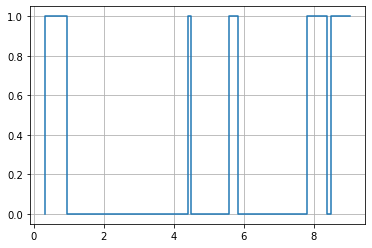

In [1001]:
import matplotlib.pyplot as plt

time_between_jobs = np.random.exponential(scale = 1/params['l'], size = params['jobs'])
t,c = get_process(time_between_jobs, **params)
events = get_events(t,c, **params)
t,c, len(t), len(c), events

x = np.concatenate((t,c))
x.sort(kind='mergesort')
y = events
plt.step(x,y[:-1])
plt.grid()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

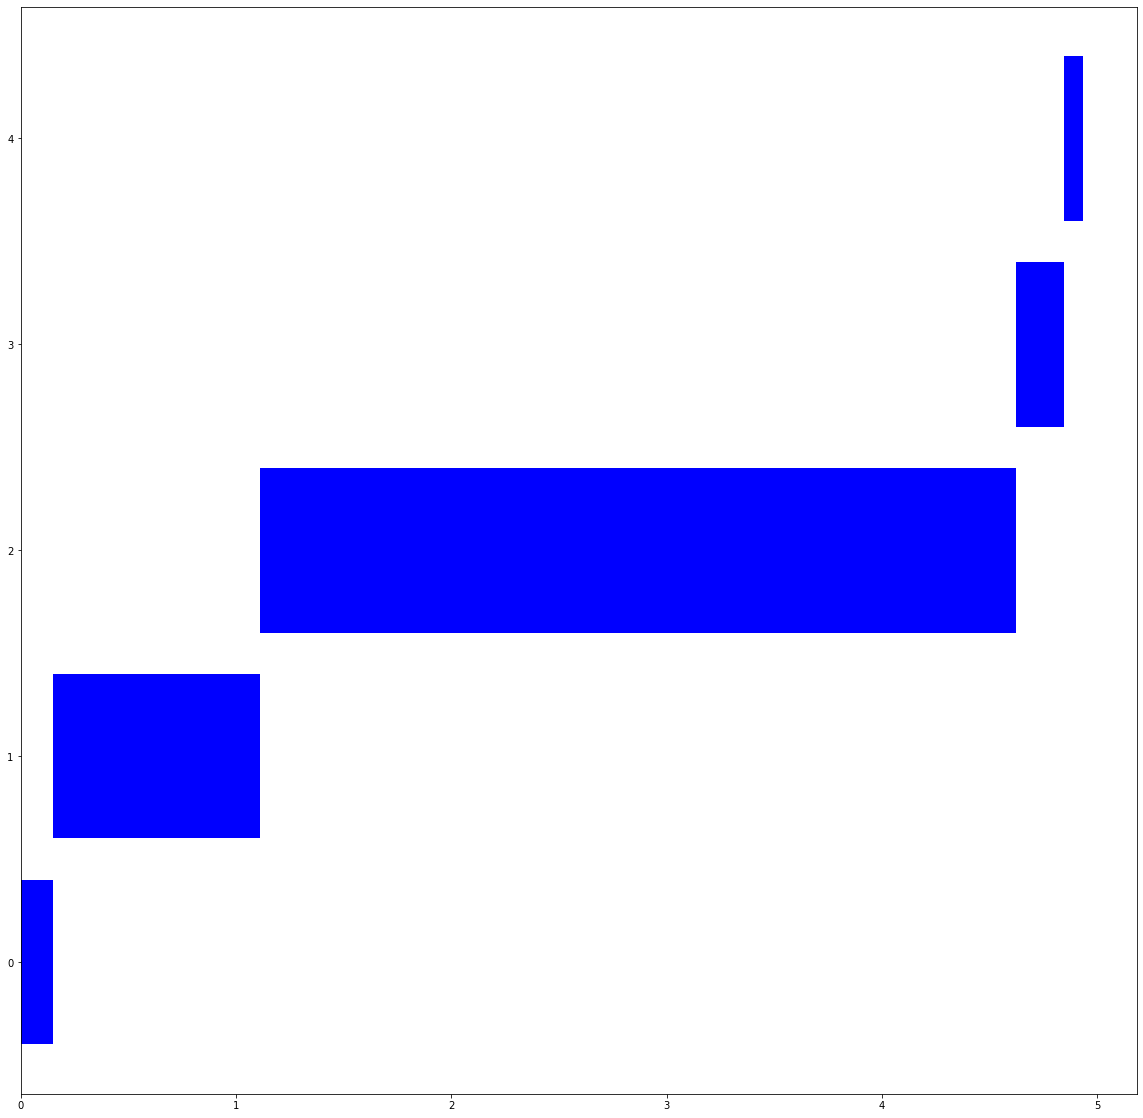

In [957]:
jobs_range = np.arange(params['jobs'])

# Смещение в правую сторону от прошлого отрезка
shift = t
shift = np.roll(shift, 1)
shift[0] = 0
plt.figure(figsize = [20,20])
plt.barh(jobs_range, time_between_jobs, left = shift, alpha = 1., color = 'blue')
plt.barh(jobs_range, jobs_handling_time, left = shift, alpha = .5, color = 'green')
plt.grid()
plt.show()

In [ ]:
plt.barh(np.zeros(len(t)), t)

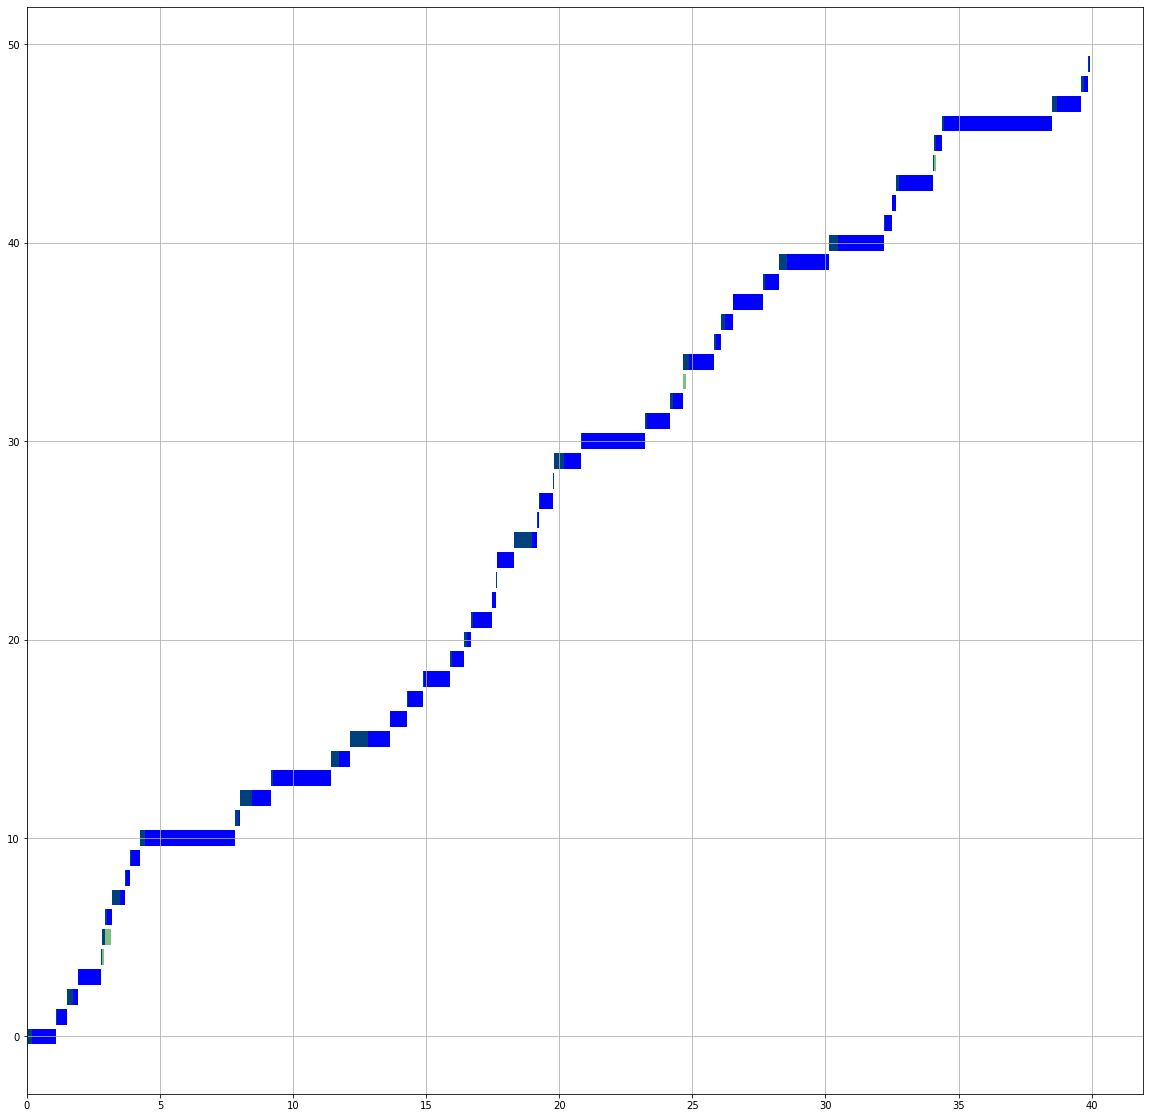

In [52]:
jobs_range = np.arange(params['jobs'])

# Смещение в правую сторону от прошлого отрезка
shift = np.cumsum(time_between_jobs)
shift = np.roll(shift, 1)
shift[0] = 0
plt.figure(figsize = [20,20])
plt.barh(jobs_range, time_between_jobs, left = shift, alpha = 1., color = 'blue')
plt.barh(jobs_range, jobs_handling_time, left = shift, alpha = .5, color = 'green')
plt.grid()
plt.show()

In [31]:
ro = params['l']/params['mu']
p0 = (1-ro)/(1-ro**(params['channels']+1))
p = []
p.append(p0)
[p.append((ro**n)*p0) for n in range(1, params['channels']+1)]

# print('Вероятность отказа: ', p1)
print('Относительная пропускная способность (Q): ', 1-p[-1])
print('Абсолютная пропускная способность (A): ', params['l']*(1-p[-1]))
print('Среднее число занятых каналов (k): ', params['channels']*params['l']*(1-p[-1])/params['mu'])

Относительная пропускная способность (Q):  0.9999999180799983
Абсолютная пропускная способность (A):  0.9999999180799983
Среднее число занятых каналов (k):  1.9999998361599967


In [ ]:
def isin(point, section):
    return section[0]<point<section[0]

In [54]:
np.random.exponential(scale = 1/l, size = 1)[0]

0.4223169626459388

In [79]:
example = np.array([1,2,3,4,5])
example[example>3]

array([4, 5])

In [80]:
# def plot_step_func(time_between_events):
#     events = []
#     events = []


In [77]:
collect_events()

2

In [75]:
3>np.array([1,2,3.5,4,5,6]), np.argmin(3>np.array([1,2,3.5,4,5,6]))

(array([ True,  True, False, False, False, False]), 2)

In [ ]:
def simulate(l, mu, channels, samples, jobs):
    pass

## Источники
* https://cyclowiki.org/wiki/%D0%A1%D0%9C%D0%9E_%D1%81_%D0%B2%D0%B7%D0%B0%D0%B8%D0%BC%D0%BE%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E
*https://cyclowiki.org/wiki/%D0%97%D0%B0%D0%BC%D0%BA%D0%BD%D1%83%D1%82%D0%B0%D1%8F_%D0%A1%D0%9C%D0%9E_%D0%B1%D0%B5%D0%B7_%D0%BE%D1%87%D0%B5%D1%80%D0%B5%D0%B4%D0%B8#:~:text=%D0%A1%D0%9C%D0%9E%20%D0%B7%D0%B0%D0%BC%D0%BA%D0%BD%D1%83%D1%82%D0%B0%D1%8F%20%D0%B1%D0%B5%D0%B7%20%D0%BE%D1%87%D0%B5%D1%80%D0%B5%D0%B4%D0%B8%20%E2%80%94%20%D1%8D%D1%82%D0%BE,%D0%BF%D0%BE%D1%82%D0%BE%D0%BA%20%D0%B7%D0%B0%D1%8F%D0%B2%D0%BE%D0%BA%20%D0%BE%D1%82%20%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%B8%D1%81%D1%82%D0%BE%D1%87%D0%BD%D0%B8%D0%BA%D0%B0.
* https://studref.com/365794/agropromyshlennost/sistemy_massovogo_obsluzhivaniya_vzaimopomoschyu